# Deep learning for robust dimensional characterisation of affect in speech
## Main Notebook

Datasets used:

*   RAVDESS, CREMA-D, TESS
*   See augment_data.ipynb for augmentation methods

In [1]:
import soundfile # read audio files
import numpy as np
import librosa # extract features
import glob
import os
import pickle # to save model after training
import time

from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import torch
from torch import nn
import torch.optim as optim

# if torch.cuda.is_available():
#     torch.backends.cudnn.deterministic = True

from sklearn.neural_network import MLPRegressor
from sklearn import preprocessing, metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split # for splitting training and testing data
from sklearn.utils import shuffle

import seaborn as sn
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.font_manager import FontProperties
%matplotlib inline

# Data handling, feature extract

In [2]:
#device setting
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
import librosa
def extract_feature(filename):
    X, sample_rate = librosa.load(filename, sr=None, dtype='float32')
    
    pre_emphasis = 0.97
    X = np.append(X[0], X[1:] - pre_emphasis * X[:-1])
    
    mfccs = librosa.feature.mfcc(y=X, sr=22050, n_mfcc=40, n_mels=40,
                                 power=2.0, window = 'hamming', fmin = 0.,
                                 fmax = 8000., hop_length=256,
                                 n_fft=1024, win_length=1024, center=True)
    return mfccs

In [4]:
# all emotions RAVDESS
int2emotion = {
    "01": "neutral",
    #"02": "calm",
    "03": "happy",
    "04": "sad",
    "05": "angry",
    "06": "fearful",
    "07": "disgust",
    #"08": "surprised"
}

# all emotions CREMA-D
cemotion = {
    "NEU": "neutral",
    "HAP": "happy",
    "SAD": "sad",
    "ANG": "angry",
    "FEA": "fearful",
    "DIS": "disgust",
}

# all emotions TESS
tessemotion = {
    "neutral.wav": "neutral",
    "happy.wav": "happy",
    "sad.wav": "sad",
    "angry.wav": "angry",
    "fear.wav": "fearful",
    "disgust.wav": "disgust",
    #"ps.wav": "surprised",
}

# all emotions SAVEE
saveeemotion = {
    "n": "neutral",
    "h": "happy",
    "s": "sad",
    "a": "angry",
    "f": "fearful",
    "d": "disgust",
    #"p": "surprised",
}

# allow only these emotions from dataset(s)
AVAILABLE_EMOTIONS = {
    "neutral",
    #"calm", # only included in RAVDESS
    "happy",
    "sad",
    "angry", 
    "fearful",
    "disgust",
    #"surprised" # in TESS specifies pleasant surprise
}

# allow only these emotions from dataset(s) for wild test
AVAILABLE_EMOTIONS_TEST = {
    "neutral",
    #"calm", # only included in RAVDESS
    "happy",
    "sad",
    "angry", 
    "fearful",
    "disgust",
    #"surprised" # in TESS specifies pleasant surprise
}

# map emotion to dimensional model space
circumplex_model = {
    "neutral":[(0.0, 0.0),"tab:grey"],
    #"calm":[(0.5, -0.7),"tab:cyan"], # only included in RAVDESS
    "happy":[(0.8, 0.1),"tab:purple"],
    "sad":[(-0.8, -0.3),"tab:blue"],
    "angry":[(-0.2, 0.7),"tab:red"],
    "fearful":[(-0.4, 0.7),"tab:olive"], 
    "disgust":[(-0.41, 0.6),"tab:green"],
    #"surprised":[(0.3, 0.7),"tab:orange"], #circumplex astonished, in TESS specifies pleasant surprise
}

In [24]:
# map emotion to dimensional model space
circumplex_model = {
    "neutral":[0.2,"tab:grey"],
    "happy":[0.8,"tab:purple"],
    "sad":[-0.8,"tab:blue"],
    "angry":[-0.1,"tab:red"],
    "fearful":[-0.3,"tab:olive"], #circumplex afraid
    "disgust":[-0.3,"tab:green"], #circumplex annoyed
}

In [7]:
# import shutil
# from google.colab import drive
# drive.mount('/content/drive')
# shutil.copyfile('/content/drive/MyDrive/data.zip', 'data.zip')
# drive.flush_and_unmount()
# shutil.unpack_archive('data.zip', 'data')

Mounted at /content/drive


In [25]:
# # load data and extract features
X, y = [], []

## RAVDESS clean
i, j = 0, 0
for file in glob.glob("data/RAVDESS-noisil/*/*.wav"):
    # get the base name of the audio file
    basename = os.path.basename(file)
    # get the emotion label
    try:
        emotion = int2emotion[basename.split("-")[2]]
        j += 1
    except:
        i += 1
        continue
    # we allow only circumplex model emotions
    if emotion not in AVAILABLE_EMOTIONS:
        continue
    # map coords
    circumplex_coord = circumplex_model[emotion][0]
    # extract features
    features = extract_feature(file)
    # add to data
    X.append(features)
    mul_circumplex_coord = [circumplex_coord] * features.shape[1]
    y.extend(mul_circumplex_coord)
print(i, j)

## RAVDESS augmented
# white noise
i, j = 0, 0
for file in glob.glob("data/augment-wn/RAVDESS/*.wav"):
    # get the base name of the audio file
    basename = os.path.basename(file)
    # get the emotion label
    try:
        emotion = int2emotion[basename.split("-")[2]]
        j += 1
    except:
        i += 1
        continue
    # we allow only AVAILABLE_EMOTIONS we set
    if emotion not in AVAILABLE_EMOTIONS:
        continue
    # map coords
    circumplex_coord = circumplex_model[emotion][0]
    # extract features
    features = extract_feature(file)
    # add to data
    X.append(features)
    mul_circumplex_coord = [circumplex_coord] * features.shape[1]
    y.extend(mul_circumplex_coord)
print(i, j)
    
# reverb
i, j = 0, 0
for file in glob.glob("data/augment-reverb/RAVDESS/*.wav"):
    # get the base name of the audio file
    basename = os.path.basename(file)
    # get the emotion label
    
    try:
        emotion = int2emotion[basename.split("-")[2]]
        j += 1
    except:
        i += 1
        continue
    # we allow only AVAILABLE_EMOTIONS we set
    if emotion not in AVAILABLE_EMOTIONS:
        continue
    # map coords
    circumplex_coord = circumplex_model[emotion][0]
    # extract features
    features = extract_feature(file)
    # add to data
    X.append(features)
    mul_circumplex_coord = [circumplex_coord] * features.shape[1]
    y.extend(mul_circumplex_coord)
print(i, j)

# overdrive
i, j = 0, 0
for file in glob.glob("data/augment-overdrive/RAVDESS/*.wav"):
    # get the base name of the audio file
    basename = os.path.basename(file)
    # get the emotion label
    
    try:
        emotion = int2emotion[basename.split("-")[2]]
        j += 1
    except:
        i += 1
        continue
    # we allow only AVAILABLE_EMOTIONS we set
    if emotion not in AVAILABLE_EMOTIONS:
        continue
    # map coords
    circumplex_coord = circumplex_model[emotion][0]
    # extract features
    features = extract_feature(file)
    # add to data
    X.append(features)
    mul_circumplex_coord = [circumplex_coord] * features.shape[1]
    y.extend(mul_circumplex_coord)
print(i, j)

# CREMA-D clean
i, j = 0, 0
for file in glob.glob("data/CREMA-D/*/*.wav"):
    # get the base name of the audio file
    basename = os.path.basename(file)
    # get the emotion label
    
    try:
        emotion = cemotion[basename.split("_")[2]]
        j += 1
    except:
        i += 1
        continue
    # we allow only AVAILABLE_EMOTIONS we set
    if emotion not in AVAILABLE_EMOTIONS:
        continue
    # map coords
    circumplex_coord = circumplex_model[emotion][0]
    # extract features
    features = extract_feature(file)
    # add to data
    X.append(features)
    mul_circumplex_coord = [circumplex_coord] * features.shape[1]
    y.extend(mul_circumplex_coord)
print(i, j)

## CREMA-D augmented
# white noise
i, j = 0, 0
for file in glob.glob("data/augment-wn/CREMA-D/*.wav"):
    # get the base name of the audio file
    basename = os.path.basename(file)
    # get the emotion label
    
    try:
        emotion = cemotion[basename.split("_")[2]]
        j += 1
    except:
        i += 1
        continue
    # we allow only AVAILABLE_EMOTIONS we set
    if emotion not in AVAILABLE_EMOTIONS:
        continue
    # map coords
    circumplex_coord = circumplex_model[emotion][0]
    # extract features
    features = extract_feature(file)
    # add to data
    X.append(features)
    mul_circumplex_coord = [circumplex_coord] * features.shape[1]
    y.extend(mul_circumplex_coord)
print(i, j)
    
# reverb
i, j = 0, 0
for file in glob.glob("data/augment-reverb/CREMA-D/*.wav"):
    # get the base name of the audio file
    basename = os.path.basename(file)
    # get the emotion label
    
    try:
        emotion = cemotion[basename.split("_")[2]]
        j += 1
    except:
        i += 1
        continue
    # we allow only AVAILABLE_EMOTIONS we set
    if emotion not in AVAILABLE_EMOTIONS:
        continue
    # map coords
    circumplex_coord = circumplex_model[emotion][0]
    # extract features
    features = extract_feature(file)
    # add to data
    X.append(features)
    mul_circumplex_coord = [circumplex_coord] * features.shape[1]
    y.extend(mul_circumplex_coord)
print(i, j)

# overdrive
i, j = 0, 0
for file in glob.glob("data/augment-overdrive/CREMA-D/*.wav"):
    # get the base name of the audio file
    basename = os.path.basename(file)
    # get the emotion label
    
    try:
        emotion = cemotion[basename.split("_")[2]]
        j += 1
    except:
        i += 1
        continue
    # we allow only AVAILABLE_EMOTIONS we set
    if emotion not in AVAILABLE_EMOTIONS:
        continue
    # map coords
    circumplex_coord = circumplex_model[emotion][0]
    # extract features
    features = extract_feature(file)
    # add to data
    X.append(features)
    mul_circumplex_coord = [circumplex_coord] * features.shape[1]
    y.extend(mul_circumplex_coord)
print(i, j)

# scale features
X = np.transpose(np.concatenate(X, axis=1))
X = preprocessing.normalize(X, norm='l2', axis=1, copy=False)
y = np.array(y)

# train test validation split
train_ratio = 0.625
validation_ratio = 0.25
test_ratio = 0.025

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1 - train_ratio, random_state=420, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio), random_state=420, stratify=y_test)

384 1056
384 1056
384 1056
2800 0
0 7442
0 7442
0 7442
0 7442


In [26]:
# Custom test set load, overwrites
Xt, yt = [], []

# TESS
for file in glob.glob("data/TESS/*/*.wav"):
    # get the base name of the audio file\n",
    basename = os.path.basename(file)
    # get the emotion label\n",
    try:
        emotion = tessemotion[basename.split("_")[2]]
    except:
        continue
    # we allow only AVAILABLE_EMOTIONS we set
    if emotion not in AVAILABLE_EMOTIONS_TEST:
        continue
    # map coords
    circumplex_coord = circumplex_model[emotion][0]
    # extract speech features
    features = extract_feature(file)
    # add to data
    Xt.append(features)
    mul_circumplex_coord = [circumplex_coord] * features.shape[1]
    yt.extend(mul_circumplex_coord)
    
# scale features
Xt = np.transpose(np.concatenate(Xt, axis=1))
Xt = preprocessing.normalize(Xt, norm='l2', axis=1, copy=False)
yt = np.array(yt)

X_bin, X_wild, y_bin, y_wild = train_test_split(Xt, yt, test_size = 0.2, random_state = 420, stratify=yt)

##Statistics

In [ ]:
# number of available samples
print("[+] Number of data samples:", X.shape[0])
# vector of features extracted 
print("[+] Number of MFCC:", X_train.shape[1])
# number of samples in training data
print("[+] Number of training samples:", X_train.shape[0])
# number of samples in validation data
print("[+] Number of validation samples:", X_val.shape[0])
# number of samples in test data
print("[+] Number of test samples:", X_test.shape[0])
# number of samples in wild data
print("[+] Number of wild test samples:", X_wild.shape[0])

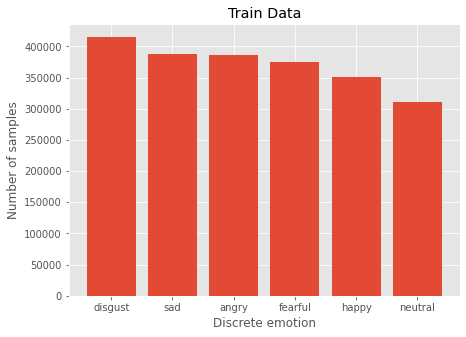

-0.263141    415027
-0.585680    387471
-0.061090    386145
-0.260545    375405
 0.980450    350055
 0.190007    310672
Name: X, dtype: int64


In [ ]:
y_train_df = pd.DataFrame(data=y_train, columns=['X'])
y_train_plot = y_train_df['X'].value_counts()

barplot_labels = []

for coord in y_train_plot.keys():
    for key, value in circumplex_model.items():
        if coord == value[0]:
            barplot_labels.append(key)

y_pos = np.arange(len(barplot_labels))

plt.figure(figsize=(7,5))
plt.style.use('ggplot')

plt.bar(y_pos, y_train_plot)

plt.xticks(y_pos, barplot_labels)
plt.yticks()

plt.xlabel("Discrete emotion")
plt.ylabel("Number of samples")
plt.title("Train Data")
plt.show()
print(y_train_plot)

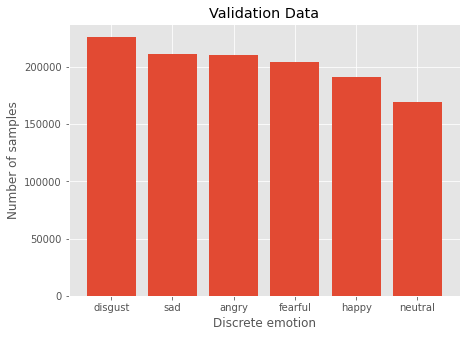

-0.263141    226379
-0.585680    211347
-0.061090    210625
-0.260545    204766
 0.980450    190939
 0.190007    169458
Name: X, dtype: int64


In [ ]:
y_val_df = pd.DataFrame(data=y_val, columns=['X'])
y_val_plot = y_val_df['X'].value_counts()

barplot_labels = []

for coord in y_val_plot.keys():
    for key, value in circumplex_model.items():
        if coord == value[0]:
            barplot_labels.append(key)

y_pos = np.arange(len(barplot_labels))

plt.figure(figsize=(7,5))
plt.style.use('ggplot')

plt.bar(y_pos, y_val_plot)

plt.xticks(y_pos, barplot_labels)
plt.yticks()
            
plt.xlabel("Discrete emotion")
plt.ylabel("Number of samples")
plt.title("Validation Data")
plt.show()
print(y_val_plot)

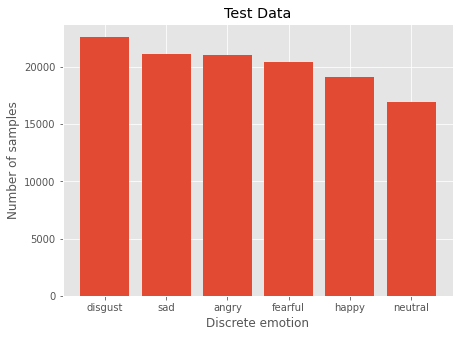

-0.263141    22638
-0.585680    21135
-0.061090    21062
-0.260545    20477
 0.980450    19094
 0.190007    16946
Name: X, dtype: int64


In [ ]:
y_test_df = pd.DataFrame(data=y_test, columns=['X'])
y_test_plot = y_test_df['X'].value_counts()

barplot_labels = []

for coord in y_test_plot.keys():
    for key, value in circumplex_model.items():
        if coord == value[0]:
            barplot_labels.append(key)

y_pos = np.arange(len(barplot_labels))

plt.figure(figsize=(7,5))
plt.style.use('ggplot')

plt.bar(y_pos, y_test_plot)

plt.xticks(y_pos, barplot_labels)
plt.yticks()

plt.xlabel("Discrete emotion")
plt.ylabel("Number of samples")
plt.title("Test Data")
plt.show()
print(y_test_plot)

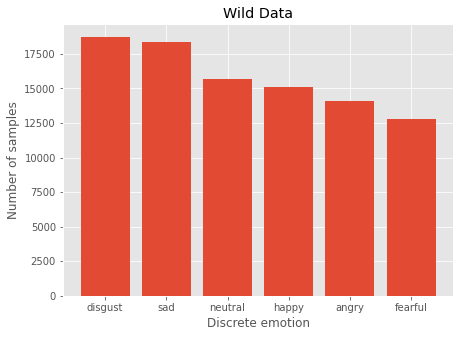

-0.263141    18722
-0.585680    18366
 0.190007    15715
 0.980450    15094
-0.061090    14087
-0.260545    12778
Name: X, dtype: int64


In [ ]:
y_wild_df = pd.DataFrame(data=y_wild, columns=['X'])
y_wild_plot = y_wild_df['X'].value_counts()

barplot_labels = []

for coord in y_wild_plot.keys():
    for key, value in circumplex_model.items():
        if coord == value[0]:
            barplot_labels.append(key)

y_pos = np.arange(len(barplot_labels))

plt.figure(figsize=(7,5))
plt.style.use('ggplot')

plt.bar(y_pos, y_wild_plot)

plt.xticks(y_pos, barplot_labels)
plt.yticks()

plt.xlabel("Discrete emotion")
plt.ylabel("Number of samples")
plt.title("Wild Data")
plt.show()
print(y_wild_plot)

# MLP PyTorch

In [27]:
class DataLoader(object):
    def __init__(self, x, y, batch_size, shuffle):
        self.x = x
        self.y = y
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.start_idx = 0
        self.data_size = x.shape[0]
        if self.shuffle:
            self.reset()
    
    def reset(self):
        self.x, self.y = shuffle(self.x, self.y)
    
    def __iter__(self):
        return self
    
    def __next__(self):
        if self.start_idx >= self.data_size:
            if self.shuffle:
                self.reset()
            self.start_idx = 0
            raise StopIteration
    
        batch_x = self.x[self.start_idx:self.start_idx+self.batch_size]
        batch_y = self.y[self.start_idx:self.start_idx+self.batch_size]

        batch_x = torch.tensor(batch_x, dtype=torch.float, device=device)
        batch_y = torch.tensor(batch_y, dtype=torch.float, device=device)

        self.start_idx += self.batch_size

        return (batch_x, batch_y)

In [28]:
train_loader = DataLoader(X_train, y_train,
                 batch_size=512,
                 shuffle=True)

val_loader = DataLoader(X_val, y_val,
                 batch_size=512,
                 shuffle=False)

print("Train Set:")
# checking the dataset
for features, labels in train_loader:  
    print('Features Dimensions:', features.shape)
    print('label dimensions:', labels.shape)
    break
    
# checking the dataset
print("Validation Set:")
for features, labels in val_loader:  
    print('Features dimensions:', features.shape)
    print('Label dimensions:', labels.shape)
    break

Train Set:
Features Dimensions: torch.Size([512, 40])
label dimensions: torch.Size([512])
Validation Set:
Features dimensions: torch.Size([512, 40])
Label dimensions: torch.Size([512])


In [ ]:
y_train.shape

(4349123,)

In [29]:
#defining model
class MLP(nn.Module):
    def __init__(self, in_dim, hidden_dim_1, hidden_dim_2, out_dim=1):
        super(MLP, self).__init__()
        
        self.in_dim = in_dim
        self.hidden_dim_1 = hidden_dim_1
        self.hidden_dim_2 = hidden_dim_2
        self.out_dim = out_dim
        
        ## 1st hidden layer
        self.linear_1 = nn.Linear(self.in_dim, self.hidden_dim_1)
        self.linear_1.weight.detach().normal_(0.0, 0.1)
        self.linear_1.bias.detach().zero_()
        self.linear_1_bn = nn.BatchNorm1d(self.hidden_dim_1,momentum=0.6)
        
        ## 2nd hidden layer
        self.linear_2 = nn.Linear(self.hidden_dim_1, self.hidden_dim_2)
        self.linear_2.weight.detach().normal_(0.0, 0.1)
        self.linear_2.bias.detach().zero_()
        self.linear_2_bn = nn.BatchNorm1d(self.hidden_dim_2,momentum=0.6)
        
        ## Out layer
        self.linear_out = nn.Linear(self.hidden_dim_2, self.out_dim)
        self.linear_out.weight.detach().normal_(0.0, 0.1)
        self.linear_out.bias.detach().zero_()
        
    def forward(self, x):
        out = self.linear_1(x)
        out = self.linear_1_bn(out)
        out = F.relu(out)
        
        out = self.linear_2(out)
        out = self.linear_2_bn(out)
        out = F.relu(out)
        out = F.dropout(out, p=0.175, training=self.training)
        
        out = self.linear_out(out)
        out = nn.Tanh()(out)
        return out.flatten()

In [30]:
#init model
mlp = MLP(40, 260, 180, 1).to(device)
optimizer = torch.optim.Adam(mlp.parameters(), lr=5e-5, weight_decay=1e-5)

In [31]:
# training phase
epochs = 50

# to plot loss curve after training
valid_losses = []
#losses = []

for epoch in range(epochs):
    start_time = time.time()
    mlp.train()
    num_batch = train_loader.data_size // train_loader.batch_size + 1
    train_loss_epoch = 0
    
    for batch_id, (batch_x, batch_y) in enumerate(train_loader):
        
        y_pred = mlp(batch_x)
        loss = F.mse_loss(y_pred, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        elapsed_time = time.time() - start_time
        elapsed_min = int(elapsed_time / 60)
        elapsed_sec = elapsed_time - 60 * elapsed_min
        
        train_loss_epoch += loss.item()

        print('\rEpoch:{} Batch:{}/{} Loss:{:.4f} Time:{}m{:.2f}s'.format(epoch + 1, batch_id, 
                                                                          num_batch, loss.item(),
                                                                          elapsed_min, elapsed_sec), end='')
    print()
    
    train_loss_epoch /= num_batch
    print(train_loss_epoch)
    #losses.append(train_loss_epoch)
    
    mlp.eval()
    valid_loss = 0
    best_loss = np.inf
    num_batch = val_loader.data_size // val_loader.batch_size + 1
    
    for batch_id, (batch_x, batch_y) in enumerate(val_loader):
        
        y_pred = mlp(batch_x)
        loss = F.mse_loss(y_pred, batch_y)
        valid_loss += loss.item()
    
    valid_loss /= num_batch
    valid_losses.append(valid_loss)
    
    #save model when validation loss is minimum
    if valid_loss < best_loss:
        best_loss = valid_loss
        torch.save(mlp.state_dict(), 'mlp.bestmodel') 
    
    print('Valid Loss:{:.4f}'.format(valid_loss))

Epoch:1 Batch:8493/8495 Loss:0.2292 Time:0m30.93s
0.27145065166902516
Valid Loss:0.2345
Epoch:2 Batch:8494/8495 Loss:0.2429 Time:0m29.52s
0.23600675451748507
Valid Loss:0.2321
Epoch:3 Batch:8494/8495 Loss:0.2538 Time:0m29.83s
0.23266630649145664
Valid Loss:0.2308
Epoch:4 Batch:8494/8495 Loss:0.1911 Time:0m29.54s
0.23146163463557448
Valid Loss:0.2304
Epoch:5 Batch:8494/8495 Loss:0.2267 Time:0m29.46s
0.23063340020958573
Valid Loss:0.2294
Epoch:6 Batch:8494/8495 Loss:0.2013 Time:0m29.33s
0.22995088939774802
Valid Loss:0.2286
Epoch:7 Batch:8494/8495 Loss:0.2228 Time:0m29.32s
0.22940388080861865
Valid Loss:0.2283
Epoch:8 Batch:8494/8495 Loss:0.2355 Time:0m29.40s
0.22888988152962
Valid Loss:0.2276
Epoch:9 Batch:8494/8495 Loss:0.2504 Time:0m29.74s
0.22842182670536287
Valid Loss:0.2275
Epoch:10 Batch:8494/8495 Loss:0.2385 Time:0m29.59s
0.22799181923787687
Valid Loss:0.2267
Epoch:11 Batch:8494/8495 Loss:0.2011 Time:0m29.57s
0.22754187823710126
Valid Loss:0.2271
Epoch:12 Batch:8494/8495 Loss:0.2

In [32]:
torch.save(mlp, 'mlp.pth')
torch.save(mlp.state_dict(), 'mlp.pt')

In [33]:
import shutil
from google.colab import drive
drive.mount('/content/drive')
shutil.copyfile('mlp.pth', '/content/drive/MyDrive/mlp.pth')
shutil.copyfile('mlp.pt', '/content/drive/MyDrive/mlp.pt')

drive.flush_and_unmount()

Mounted at /content/drive


In [34]:
mlp = MLP(40, 260, 180, 1).to(device)
mlp.load_state_dict(torch.load('mlp.pt'))

<All keys matched successfully>